In [20]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info_full.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'xin']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['xin'] = {'species': 'hsapiens', 'dname': 'Xin 2018'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.px18': DATA_PATH+'/score_file/score.tms_facs_with_cov.pancreas_xin_2018',
                  'xin': DATA_PATH+'/score_file/score.xin_with_cov.magma_10kb_1000',
                  'xin.px18': DATA_PATH+'/score_file/score.xin_with_cov.pancreas_xin_2018',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['PASS_FastingGlucose_Manning',
                          'UKB_460K.biochemistry_Glucose',
                          'UKB_460K.biochemistry_HbA1c',
                          'PASS_Type_2_Diabetes',
                          'PASS_Intelligence_SavageJansen2018',
                          'PASS_VerbalNumericReasoning_Davies2018',
                          'UKB_460K.body_BMIz',
                          'UKB_460K.impedance_BASAL_METABOLIC_RATEz',
                          'UKB_460K.body_HEIGHTz']
DIC_TRAIT_LIST['facs.px18'] = ['UPR', 'Apoptosis', 'Senescence', 'Cell_cycle_G1S', 'Cell_cycle_G2M',
                               'Beta_sub1', 'Beta_sub2', 'Beta_sub3', 'Beta_sub4']
DIC_TRAIT_LIST['xin'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['xin.px18'] = DIC_TRAIT_LIST['facs.px18'].copy()

# Set trait info
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short
    
for trait in DIC_TRAIT_LIST['facs.px18']:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, trait]

### Load data 

In [14]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_raw['xin'] = dl.load_xin_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/pan_b.facs.h5ad')
dic_data_proc['xin'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/pan_b.xin.h5ad')

# Add mt_prop to facs fata
temp_adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/'
                       'adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['mt_prop'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df['mt_prop'])
dic_data_proc['facs'].obs['mt_prop'] = df_mt['mt_prop'].values

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.split('.')[0]
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

In [5]:
# Compute correlation between n_gene and score 
dic_data_raw['facs'].obs['n_genes'] = (dic_data_raw['facs'].X>0).sum(axis=1)
df_plot = dic_data_raw['facs'].obs[['n_genes']]
df_plot = df_plot.join(dic_score['facs'])
df_plot = df_plot.loc[df_plot.isna().sum(axis=1)==0]
for trait in DIC_TRAIT_LIST['facs']:
    print('# %-30s    corr=%0.3f'%(trait, np.corrcoef(df_plot['n_genes'], df_plot['%s.norm_score'%trait])[0,1]))

# PASS_FastingGlucose_Manning       corr=-0.019
# UKB_460K.biochemistry_Glucose     corr=-0.014
# UKB_460K.biochemistry_HbA1c       corr=-0.005
# PASS_Type_2_Diabetes              corr=0.002
# PASS_Intelligence_SavageJansen2018    corr=-0.030
# PASS_VerbalNumericReasoning_Davies2018    corr=-0.031
# UKB_460K.body_BMIz                corr=-0.025
# UKB_460K.impedance_BASAL_METABOLIC_RATEz    corr=-0.007
# UKB_460K.body_HEIGHTz             corr=0.002


In [6]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani.hm']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs PASS_FastingGlucose_Manning
# Loading facs UKB_460K.biochemistry_Glucose
# Loading facs UKB_460K.biochemistry_HbA1c
# Loading facs PASS_Type_2_Diabetes
# Loading facs PASS_Intelligence_SavageJansen2018
# Loading facs PASS_VerbalNumericReasoning_Davies2018
# Loading facs UKB_460K.body_BMIz
# Loading facs UKB_460K.impedance_BASAL_METABOLIC_RATEz
# Loading facs UKB_460K.body_HEIGHTz
# Loading facs.px18 UPR
# Loading facs.px18 Apoptosis
# Loading facs.px18 Senescence
# Loading facs.px18 Cell_cycle_G1S
# Loading facs.px18 Cell_cycle_G2M
# Loading facs.px18 Beta_sub1
# Loading facs.px18 Beta_sub2
# Loading facs.px18 Beta_sub3
# Loading facs.px18 Beta_sub4
# Loading xin PASS_FastingGlucose_Manning
# Loading xin UKB_460K.biochemistry_Glucose
# Loading xin UKB_460K.biochemistry_HbA1c
# Loading xin PASS_Type_2_Diabetes
# Loading xin PASS_Intelligence_SavageJansen2018
# Loading xin PASS_VerbalNumericReasoning_Davies2018
# Loading xin UKB_460K.body_BMIz
# Loading xin UKB_460K.impeda

### UMAP for all pancreatic beta cells 

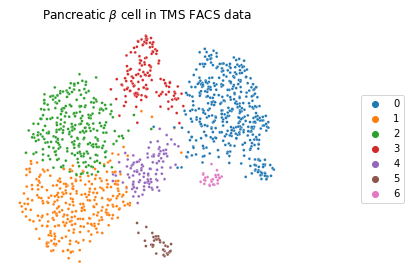

In [70]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs[['leiden', 'cell_ontology_class']])

plt.figure(figsize=[6,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Pancreatic $\\beta$ cell in TMS FACS data')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

PASS_FastingGlucose_Manning


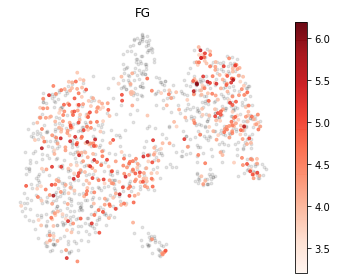

UKB_460K.biochemistry_Glucose


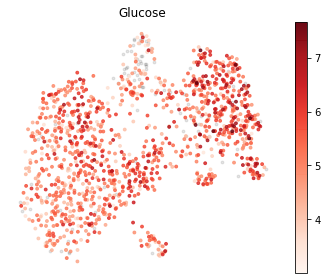

UKB_460K.biochemistry_HbA1c


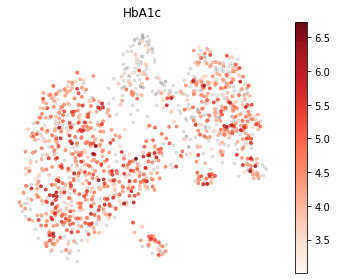

PASS_Type_2_Diabetes


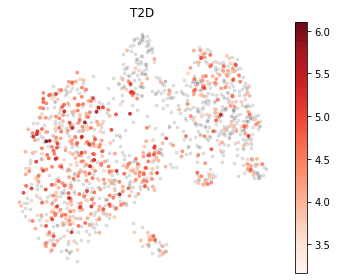

PASS_Intelligence_SavageJansen2018


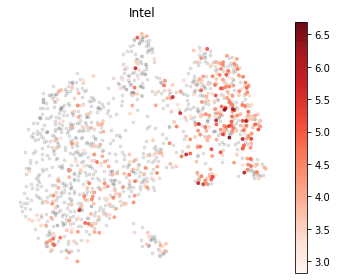

PASS_VerbalNumericReasoning_Davies2018


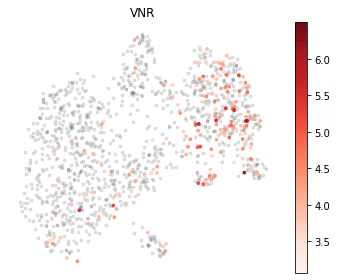

UKB_460K.body_BMIz


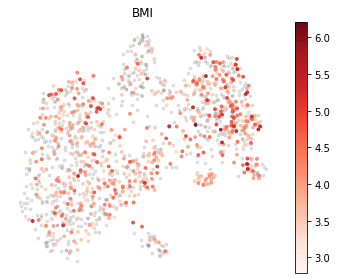

UKB_460K.impedance_BASAL_METABOLIC_RATEz


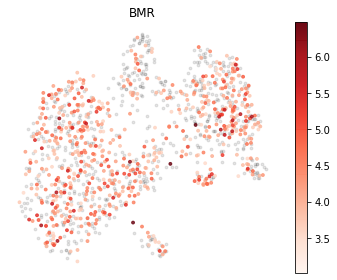

In [14]:
score = 'facs'
ds = score.split('.')[0]
for trait in DIC_TRAIT_LIST[score]:
    print(trait)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.join(dic_score[score][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
#     if ind_select.sum()<10:
#         continue
    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()

PASS_FastingGlucose_Manning


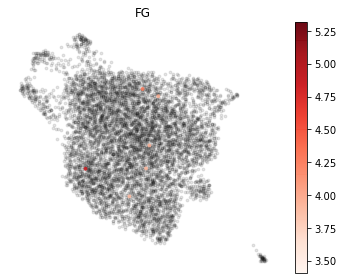

UKB_460K.biochemistry_Glucose


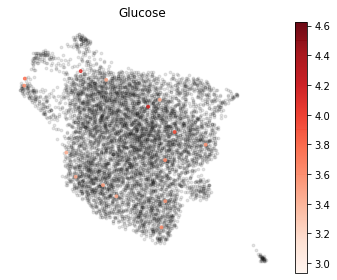

UKB_460K.biochemistry_HbA1c


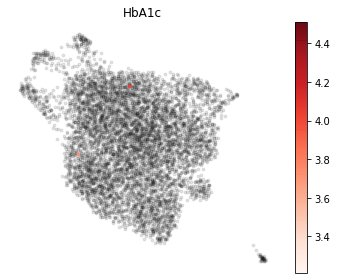

PASS_Type_2_Diabetes
PASS_Intelligence_SavageJansen2018


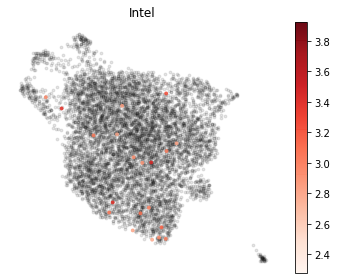

PASS_VerbalNumericReasoning_Davies2018


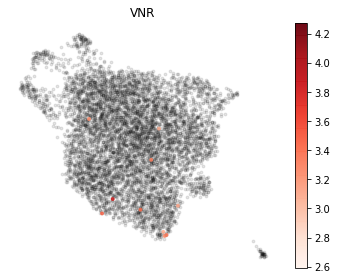

UKB_460K.body_BMIz


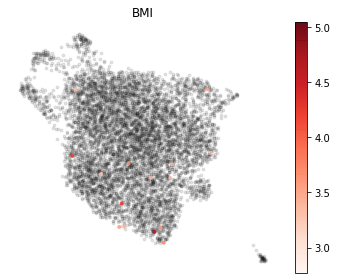

UKB_460K.impedance_BASAL_METABOLIC_RATEz


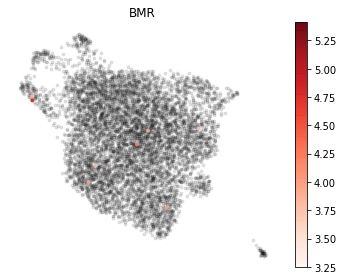

UKB_460K.body_HEIGHTz


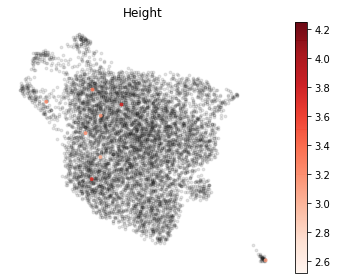

In [9]:
score = 'xin'
ds = score.split('.')[0]
for trait in DIC_TRAIT_LIST[score]:
    print(trait)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.join(dic_score[score][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.5
#     ind_select = df_plot['%s.nlog10_pval'%trait]>2
    if ind_select.sum()<1:
        continue
    
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()

In [10]:
score = 'facs'
temp_df = dic_score[score][['%s.norm_score'%x for x in DIC_TRAIT_LIST[score]]]
temp_df.columns = [DF_TRAIT_INFO.loc[x.replace('.norm_score',''), 'Code'] for x in temp_df.columns]
display(temp_df.corr())

,FG,Glucose,HbA1c,T2D,Intel,VNR,BMI,BMR,Height
FG,1.000000,0.420605,0.323864,0.184711,0.245645,0.244148,0.191316,0.211650,0.059226
Glucose,0.420605,1.000000,0.472627,0.246262,0.188153,0.186661,0.146813,0.217273,0.079583
HbA1c,0.323864,0.472627,1.000000,0.209053,0.190941,0.178648,0.152971,0.181380,0.042863
T2D,0.184711,0.246262,0.209053,1.000000,0.123334,0.105335,0.199270,0.250584,0.217309
Intel,0.245645,0.188153,0.190941,0.123334,1.000000,0.773972,0.500557,0.395771,0.079736
VNR,0.244148,0.186661,0.178648,0.105335,0.773972,1.000000,0.418259,0.323423,0.105307
BMI,0.191316,0.146813,0.152971,0.199270,0.500557,0.418259,1.000000,0.558388,0.192168
BMR,0.211650,0.217273,0.181380,0.250584,0.395771,0.323423,0.558388,1.000000,0.339952
Height,0.059226,0.079583,0.042863,0.217309,0.079736,0.105307,0.192168,0.339952,1.000000


In [11]:
score = 'xin'
temp_df = dic_score[score][['%s.norm_score'%x for x in DIC_TRAIT_LIST[score]]]
temp_df.columns = [DF_TRAIT_INFO.loc[x.replace('.norm_score',''), 'Code'] for x in temp_df.columns]
display(temp_df.corr())

,FG,Glucose,HbA1c,T2D,Intel,VNR,BMI,BMR,Height
FG,1.000000,0.293063,0.172749,0.087400,0.037574,0.060593,0.059929,0.072956,0.048404
Glucose,0.293063,1.000000,0.319859,0.189735,0.067658,0.075599,0.119108,0.160589,0.038336
HbA1c,0.172749,0.319859,1.000000,0.162073,0.101509,0.095276,0.131506,0.170184,0.120525
T2D,0.087400,0.189735,0.162073,1.000000,0.038158,0.061174,0.094538,0.082243,0.021029
Intel,0.037574,0.067658,0.101509,0.038158,1.000000,0.702781,0.283232,0.214065,0.179397
VNR,0.060593,0.075599,0.095276,0.061174,0.702781,1.000000,0.277201,0.206355,0.120671
BMI,0.059929,0.119108,0.131506,0.094538,0.283232,0.277201,1.000000,0.372974,0.127453
BMR,0.072956,0.160589,0.170184,0.082243,0.214065,0.206355,0.372974,1.000000,0.246507
Height,0.048404,0.038336,0.120525,0.021029,0.179397,0.120671,0.127453,0.246507,1.000000


### Correlation with BMI

In [32]:
# Curate covariates 
dic_cov = {}
# dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
# dic_cov['facs']['age_num'] = [int(x.replace('m','')) for x in dic_cov['facs']['age']]
# dic_cov['facs'] = dic_cov['facs'][['age_num', 'mt_prop']].copy()

dic_cov['xin'] = dic_data_proc['xin'].obs.copy()
dic_cov['xin']['Height_num'] = [int(x[0])+int(x[2])/12 for x in dic_cov['xin']['HbA1c']]
dic_cov['xin']['HbA1c_num'] = [float(x.split('%')[0])/100 for x in dic_cov['xin']['HbA1c']]
dic_cov['xin']['Sex'] = [(x=='M')*1 for x in dic_cov['xin']['Sex']]
dic_cov['xin'] = dic_cov['xin'][['viability', 'Age', 'Sex', 'BMI', 'Height_num', 'Weight (lbs)', 'HbA1c_num']].copy()

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1

In [51]:
# Joint regression analysis
dic_reg = {'reg_joint': ['BMI', 'Height_num', 'Weight (lbs)', 'HbA1c_num'],
           'reg_bmi': ['BMI'],
           'reg_height': ['Height_num'],
           'reg_weight': ['Weight (lbs)'], 
           'reg_hba1c': ['HbA1c_num']
            }

dic_stats = {}
for cov_name in dic_cov:
    ctrl_list = ['const', 'Age', 'Sex', 'viability']
    ctrl_list = ['const', 'Age', 'Sex']
    for reg_name in dic_reg:
        print(cov_name, reg_name)
        reg_list = dic_reg[reg_name]
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in [ds]:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue             

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(500) for x in reg_list}

                for i in range(500):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]

                dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / 501 for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [util.p_2_str_num(x) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

xin reg_joint
xin reg_bmi
xin reg_height
xin reg_weight
xin reg_hba1c


In [52]:
dic_stats['xin.reg_height']

,var_ctrl,var,T.Height_num,P.Height_num,P_STR.Height_num,P_STR_NUM.Height_num
PASS_FastingGlucose_Manning,0.002855,0.002755,0.538292,0.427146,,P=0.427
UKB_460K.biochemistry_Glucose,0.008347,0.008520,1.495880,0.343313,,P=0.343
UKB_460K.biochemistry_HbA1c,0.013170,0.013083,0.613628,0.453094,,P=0.453
PASS_Type_2_Diabetes,0.010669,0.016517,-6.569849,0.922156,,P=0.922
PASS_Intelligence_SavageJansen2018,0.013269,0.013774,2.151770,0.313373,,P=0.313
PASS_VerbalNumericReasoning_Davies2018,0.002912,0.002772,0.010674,0.502994,,P=0.503
UKB_460K.body_BMIz,0.011955,0.016581,5.861122,0.013972,*,P=0.014
UKB_460K.impedance_BASAL_METABOLIC_RATEz,0.010553,0.011964,3.335751,0.161677,,P=0.162
UKB_460K.body_HEIGHTz,0.017401,0.017838,2.039083,0.295409,,P=0.295


In [53]:
dic_stats['xin.reg_bmi']

,var_ctrl,var,T.BMI,P.BMI,P_STR.BMI,P_STR_NUM.BMI
PASS_FastingGlucose_Manning,0.002855,0.004139,-3.185170,0.828343,,P=0.828
UKB_460K.biochemistry_Glucose,0.008347,0.012247,5.384229,0.139721,,P=0.140
UKB_460K.biochemistry_HbA1c,0.013170,0.019041,6.590204,0.059880,,P=0.060
PASS_Type_2_Diabetes,0.010669,0.014190,5.130653,0.189621,,P=0.190
PASS_Intelligence_SavageJansen2018,0.013269,0.015598,4.215757,0.157685,,P=0.158
PASS_VerbalNumericReasoning_Davies2018,0.002912,0.004222,3.213590,0.193613,,P=0.194
UKB_460K.body_BMIz,0.011955,0.019555,7.480625,0.023952,*,P=0.024
UKB_460K.impedance_BASAL_METABOLIC_RATEz,0.010553,0.021411,8.925800,0.011976,*,P=0.012
UKB_460K.body_HEIGHTz,0.017401,0.017407,1.021283,0.439122,,P=0.439


In [27]:
dic_stats['xin.reg_joint'].loc['UKB_460K.body_BMIz']

var_ctrl                 -2.22045e-16
var                         0.0377614
T.viability                   9.16742
P.viability                0.00598802
T.Age                         -3.8063
P.Age                         0.89022
T.BMI                       -0.339397
P.BMI                        0.526946
T.Height_num                 -3.23582
P.Height_num                 0.902196
T.Weight (lbs)                3.70509
P.Weight (lbs)               0.131737
T.HbA1c_num                   3.96569
P.HbA1c_num                 0.0558882
P_STR.viability                     *
P_STR_NUM.viability           P=0.006
P_STR.Age                            
P_STR_NUM.Age                 P=0.890
P_STR.BMI                            
P_STR_NUM.BMI                 P=0.527
P_STR.Height_num                     
P_STR_NUM.Height_num          P=0.902
P_STR.Weight (lbs)                   
P_STR_NUM.Weight (lbs)        P=0.132
P_STR.HbA1c_num                      
P_STR_NUM.HbA1c_num           P=0.056
Name: UKB_46

In [59]:
# Compute p-value
df_stats = pd.DataFrame(columns=['COV', 'TRAIT', 'CORR', 'P'])
score='xin'
ds=score.split('.')[0]

for cov in dic_cov[ds].columns:
    for trait in DIC_TRAIT_LIST[ds]:
        df_plot = dic_cov[ds][[cov]].copy()
        df_plot = df_plot.join(dic_score[score][['%s.norm_score'%trait]])
        df_plot = df_plot.join(dic_ctrl_score[score][trait])
        corr_ = sp.stats.pearsonr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
#             corr_ = sp.stats.spearmanr(df_plot[cov].values, df_plot['%s.norm_score'%trait].values)[0]
        v_corr_ = np.zeros(500)
        for i in range(500):
            v_corr_[i] = sp.stats.pearsonr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 v_corr_[i] = sp.stats.spearmanr(df_plot[cov].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
        p_ = ((corr_ <= v_corr_).sum()+1) / 501
        df_stats.loc['%s.%s'%(cov,trait)] = [cov, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

In [60]:
df_stats

,COV,TRAIT,CORR,P,P_STR,P_STR_NUM
viability.PASS_FastingGlucose_Manning,viability,PASS_FastingGlucose_Manning,-0.009141,0.572854,n.s.,P=0.573
viability.UKB_460K.biochemistry_Glucose,viability,UKB_460K.biochemistry_Glucose,0.092352,0.021956,*,P=0.022
viability.UKB_460K.biochemistry_HbA1c,viability,UKB_460K.biochemistry_HbA1c,0.109644,0.005988,**,P=0.006
viability.PASS_Type_2_Diabetes,viability,PASS_Type_2_Diabetes,0.028253,0.231537,n.s.,P=0.232
viability.PASS_Intelligence_SavageJansen2018,viability,PASS_Intelligence_SavageJansen2018,0.157123,0.001996,***,P<0.002
viability.PASS_VerbalNumericReasoning_Davies2018,viability,PASS_VerbalNumericReasoning_Davies2018,0.124755,0.003992,***,P=0.004
viability.UKB_460K.body_BMIz,viability,UKB_460K.body_BMIz,0.106780,0.011976,*,P=0.012
viability.UKB_460K.impedance_BASAL_METABOLIC_RATEz,viability,UKB_460K.impedance_BASAL_METABOLIC_RATEz,0.138093,0.001996,***,P<0.002
Age.PASS_FastingGlucose_Manning,Age,PASS_FastingGlucose_Manning,-0.011359,0.606786,n.s.,P=0.607
Age.UKB_460K.biochemistry_Glucose,Age,UKB_460K.biochemistry_Glucose,-0.061265,0.942116,n.s.,P=0.942
